RFM Calculation Engine


In [5]:


import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv(r'C:\Users\91986\OneDrive\Desktop\E-comCustomerSegmentation\data\cleaned_data.csv')

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date').max()


In [8]:
snapshot_date = df.index.max() + pd.Timedelta(days=1)

In [9]:
print(snapshot_date)

2019-12-10 00:00:00


In [10]:
print(df.head())

            TransactionNo ProductNo                      ProductName   Price  \
Date                                                                           
2018-12-01         536597    90214V  Zinc Willie Winkie Candle Stick  179.37   
2018-12-02         536846     90204  Zinc Willie Winkie Candle Stick  660.62   
2018-12-03         537036    90214Y  Zinc Willie Winkie Candle Stick   45.10   
2018-12-05         537225    90210B  Zinc Willie Winkie Candle Stick   61.45   
2018-12-06         537442    90214V  Zinc Willie Winkie Candle Stick   88.71   

            Quantity  CustomerNo         Country  TotalPrice  
Date                                                          
2018-12-01       600       18229  United Kingdom      6585.6  
2018-12-02      2880       18239  United Kingdom     30038.4  
2018-12-03      1440       17967  United Kingdom     14990.4  
2018-12-05       720       18156  United Kingdom      7495.2  
2018-12-06       480       18219  United Kingdom      6585.6 

In [11]:
rfm = df.reset_index().groupby(['CustomerNo']).agg({
    'Date': lambda x: (snapshot_date - x.max()).days, 
    'TransactionNo': 'nunique',                                  
    'Price': 'sum'                                      
})

In [12]:
rfm.rename(columns={
    'Date': 'Recency',
    'TransactionNo': 'Frequency',
    'Price': 'Monetary'
}, inplace=True)

In [13]:
print(rfm.info())

<class 'pandas.core.frame.DataFrame'>
Index: 138 entries, 17392 to 18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    138 non-null    int64  
 1   Frequency  138 non-null    int64  
 2   Monetary   138 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 4.3 KB
None


Scoring & Segmentation


In [14]:
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

In [15]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=f_labels).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=m_labels).astype(int)

In [16]:
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

In [17]:
print(rfm.head())

            Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
CustomerNo                                                            
17392           307          1     27.62        1        1        1   
17602           125          1     26.60        3        1        1   
17615           223          1     32.75        2        1        1   
17667           281          1     35.83        1        1        1   
17755           102          1     70.00        3        1        2   

           RFM_Segment  RFM_Score  
CustomerNo                         
17392              111          3  
17602              311          5  
17615              211          4  
17667              111          3  
17755              312          6  


In [18]:
def get_segment(row):
    if row['RFM_Score'] >= 9:
        return 'Champions' 
    elif row['RFM_Score'] >= 8:
        return 'Loyal Customers'
    elif row['RFM_Score'] >= 6:
        return 'Potential Loyalists'
    elif row['RFM_Score'] >= 5:
        return 'At Risk' 
    else:
        return 'Hibernating/Lost'

rfm['Customer_Segment'] = rfm.apply(get_segment, axis=1)

Visualizations
1. Distribution of Segments
2. Recency vs Frequency ( Standard RFM view)

C:\Users\91986\AppData\Local\Temp\ipykernel_19544\1099921474.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Customer_Segment', data=rfm, order=rfm['Customer_Segment'].value_counts().index, palette='viridis')


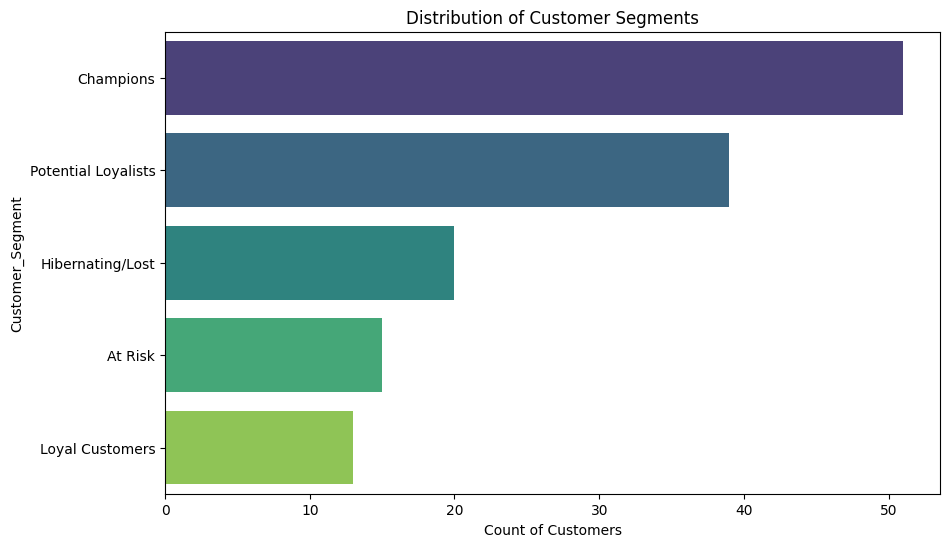

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Customer_Segment', data=rfm, order=rfm['Customer_Segment'].value_counts().index, palette='viridis')
plt.title('Distribution of Customer Segments')
plt.xlabel('Count of Customers')
plt.show()

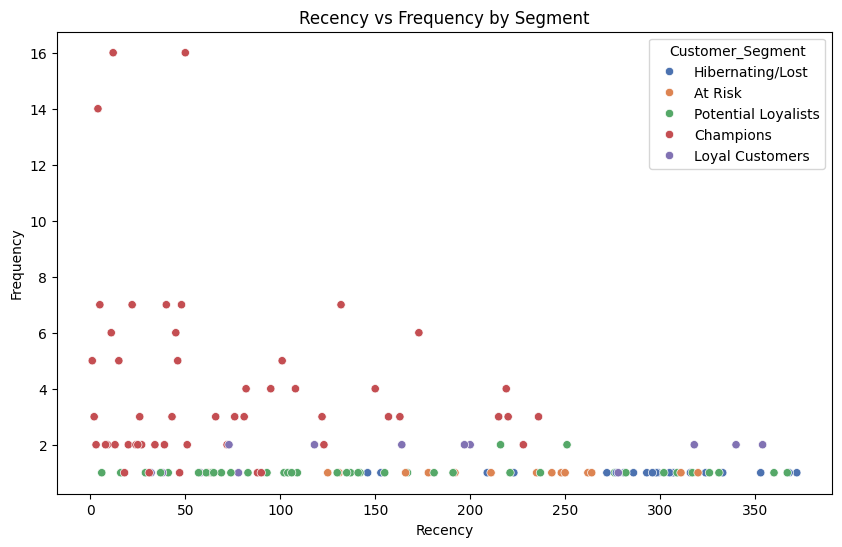

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Customer_Segment', data=rfm, palette='deep')
plt.title('Recency vs Frequency by Segment')
plt.show()

In [21]:

rfm.to_csv('RFM_Analyzed_Data.csv', index=False)